# Number of Active and Non-Active bands according to Genre and Country

In [2]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import datetime
import calendar
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None #'warn'
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as p
import string
import re
import itertools
import string
import re
import itertools
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
np.random.seed(10)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('whitegrid')
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import networkx as nx

In [4]:
#album_details = pd.read_csv("Album_Details.csv", sep = ",", na_values=["N/A"], encoding = 'latin-1')
band_details = pd.read_csv("World_Music_Bands_Details.csv",sep = ",", na_values=["N/A"], encoding = 'latin-1' )
#review_details = pd.read_csv("Reviews_Details.csv",sep = ",", na_values=["N/A"], encoding = 'latin-1' )
#band_details.head()

In [ ]:
def replace_punctuation(raw, replacement=' '):
    """Replaces all punctuation in the input string `raw` with a space.
    Returns the new string."""
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    output = regex.sub(replacement, raw)
    return output

def split_terms(raw):
    """Splits the terms in the input string `raw` on all spaces and punctuation.
    Returns a list of the terms in the string."""
    replaced = replace_punctuation(raw, replacement=' ')
    output = tuple(replaced.split())
    return output

band_details['GenreTerms'] = band_details['Band_Genre'].str.replace('Metal', '').map(split_terms)

array([[ -1.80967328e+00,  -1.38394971e-01,  -3.97135180e-01, ...,
         -5.99423968e-17,  -4.60025593e-17,   2.04514225e-16],
       [  3.21667520e-02,   5.14131317e-01,   3.60774270e-01, ...,
         -6.26826957e-19,  -4.81055911e-19,   1.22970501e-15],
       [ -1.80967328e+00,  -1.38394971e-01,  -3.97135180e-01, ...,
         -3.84138877e-18,   1.75517000e-18,  -1.71540558e-17],
       ..., 
       [  1.30225041e+00,   1.99722173e+00,  -9.47073350e-02, ...,
          1.96724121e-18,   2.02523236e-18,   4.47233702e-18],
       [  5.50025677e-01,   2.39415057e+00,  -1.42267288e-01, ...,
          2.45302651e-18,   4.03530305e-18,   4.70074858e-17],
       [  8.41977193e-01,   2.31253658e+00,  -1.14309910e-01, ...,
          2.16260620e-18,   2.46242705e-18,  -6.01513802e-18]])

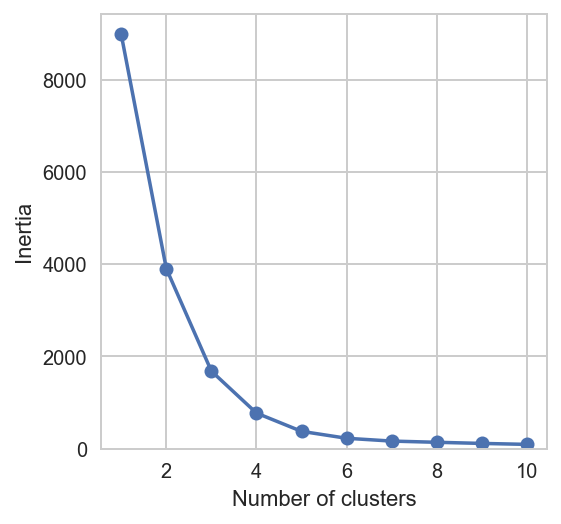

In [6]:
all_terms = list(itertools.chain.from_iterable(band_details['GenreTerms']))      # Flatten terms to a single list
unique_terms, counts = np.unique(all_terms, return_counts=True)          # Get unique terms & counts
genre_terms = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame for later
genre_terms.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count

mlb = MultiLabelBinarizer()
mlb.fit([[x] for x in [term for term in unique_terms]])
# We can use 8-bit integers to save on memory since it is only a binary matrix.
binarized_terms = mlb.transform(subset).astype('int8')

pca = PCA()
components = pca.fit_transform(binarized_terms)

In [39]:
genre_terms.head(10)

,Term,TotalCount
106,Rock,4110
9,Alternative,3444
33,Death,2621
96,Pop,1126
84,Melodic,691
120,Thrash,611
14,Black,520
31,Dance,385
133,early,293
139,later,289


In [14]:
db = DBSCAN(eps=0.1, min_samples=40)
db_clust = db.fit_predict(components[:,[0,1,2]])

In [15]:
np.unique(db_clust) # Number of clusters

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [47]:
descriptors = band_details['Band_Genre'][subset.index]  # Unprocessed descriptor strings
clusters = np.unique(db_clust)

for cluster in clusters:
    print('Cluster {}:'.format(cluster))
    cluster_term_sets = descriptors[db_clust == cluster]            # pull out genre terms, concatenate
    terms, counts = np.unique(cluster_term_sets, return_counts=True) # find unique terms within centroid
    df = pd.DataFrame([terms, counts], index=['top terms', 'counts']).T
    df.sort_values('counts', ascending=False, inplace=True)
    for i, (term, count) in df.head(1).iterrows():
        print('\t{} : {}'.format(term, count))

Cluster 1:
	Melodic Death/Thrash Metal : 22
Cluster 2:
	Rock : 821
Cluster 3:
	Death Metal : 92
Cluster 4:
	Alternative : 670
Cluster 5:
	Pop : 222
Cluster 6:
	Dance : 83
Cluster 7:
	Metal : 114


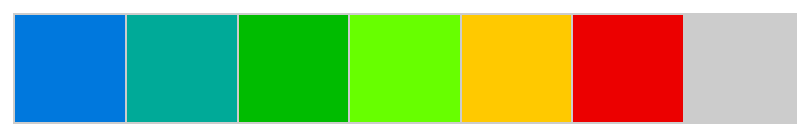

In [48]:
db_clust = db_clust + 1
clusters = list(np.unique(db_clust))
colors = [rgb2hex(color) for color in plt.cm.spectral(clusters/max(clusters))]
sns.palplot(colors)

In [24]:
def count_terms(series_of_term_tuples):
    """Takes an iterable containing iterables of the terms in a genre descriptor.
    Returns a data frame containing counts of all the terms, starting with the most common
    and ending with the least common."""
    all_terms = list(itertools.chain.from_iterable(series_of_term_tuples))
    terms, counts = np.unique(all_terms, return_counts=True)
    counted_terms = pd.DataFrame({'Term': terms, 'Count': counts})
    counted_terms.sort_values(by='Count', ascending=False, inplace=True)
    counted_terms.reset_index(inplace=True, drop=True)
    return counted_terms

IndexError: list index out of range

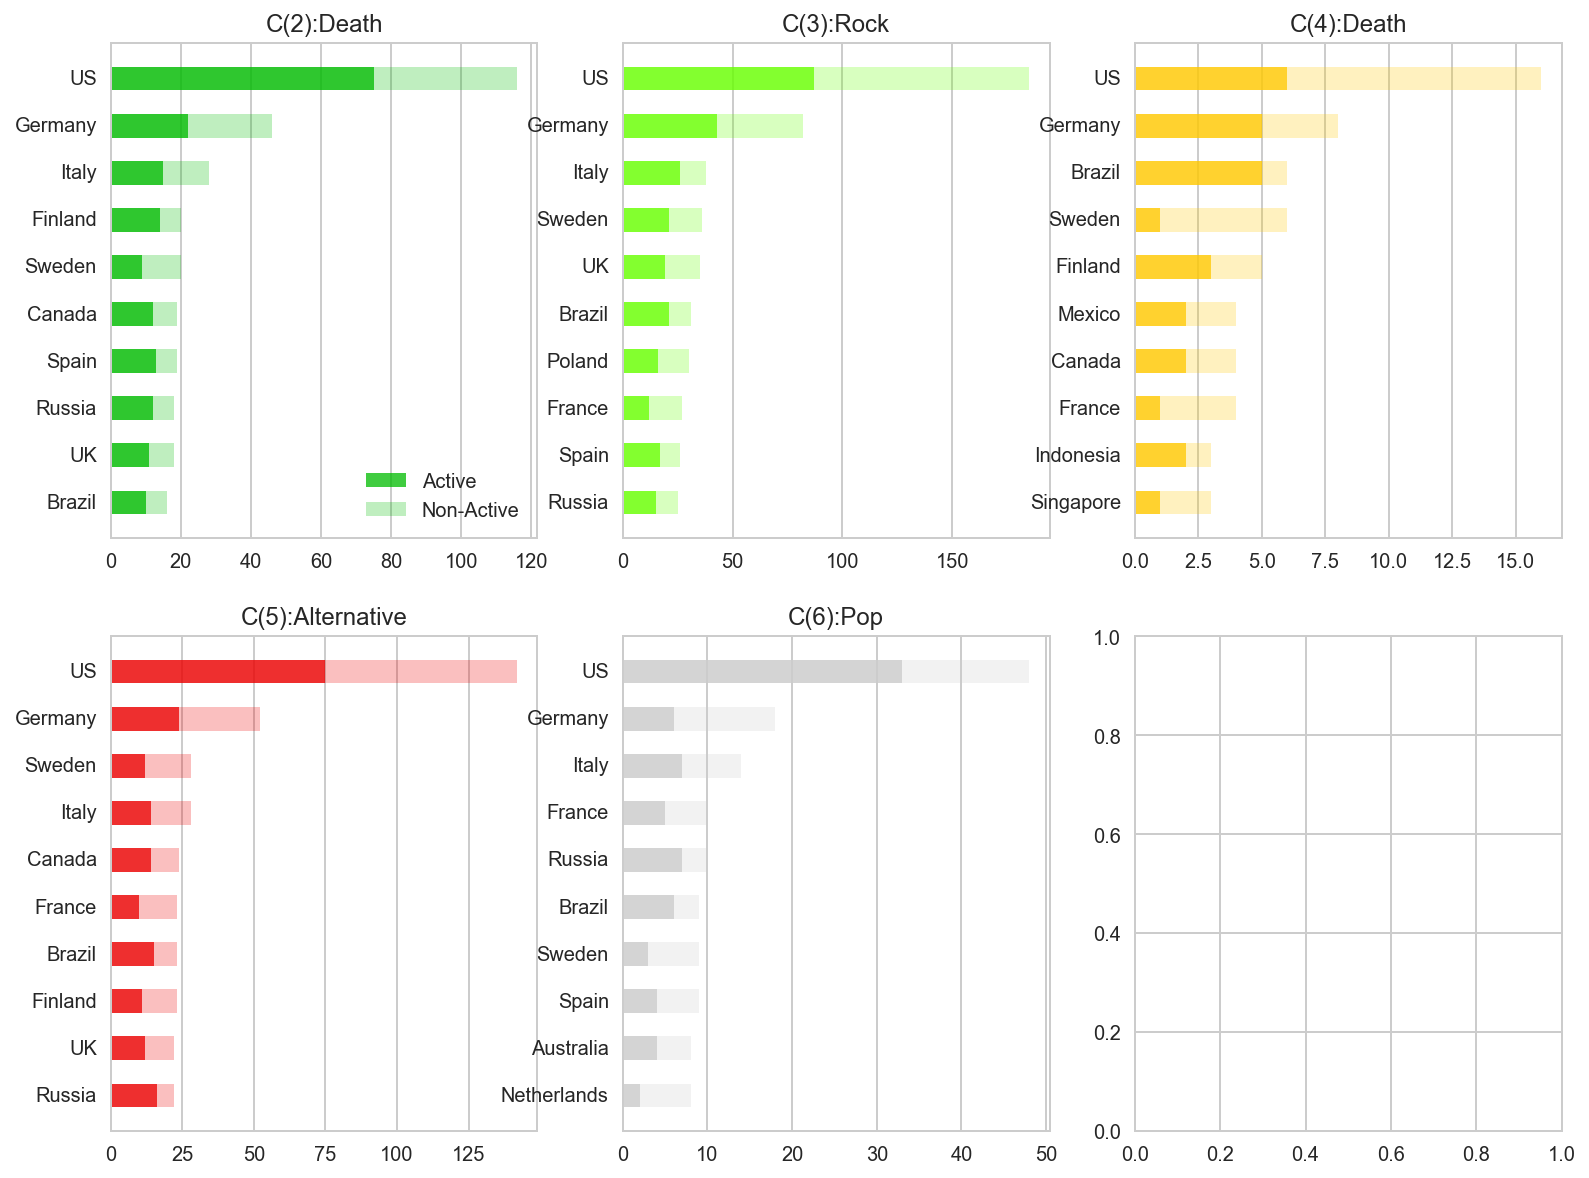

In [59]:
# We have 5 clusters which we can put on a 2x3 grid of plots, and disable the last  plot
fig, ax = plt.subplots(int(len(clusters)/4)+1,3,figsize=(13,10))

ax = ax.ravel() # This makes iterating over axes simpler 

for i, (cluster, axes) in enumerate(zip(clusters, ax)): # One plot per centroid
    # Pull out cluster genre data
    indices = subset[db_clust == cluster].index
    cluster_data = band_details.loc[indices]
    
    # Pull out counts per country, greatest first, also get number of active bands per country
    count = cluster_data.groupby('Country')['GenreTerms'].count().sort_values(ascending=False)
    count_active = cluster_data[cluster_data['Band_Status'] == 'Active'].groupby('Country')['GenreTerms'].count()
    # Pull out top most common term
    term_count = count_terms(cluster_data['GenreTerms'])
    top_terms = term_count['Term'][:1]

    # Define color for cluster
    color = colors[cluster]
    # Define y-axis coordinates
    coords = np.arange(10, 0, -1)
    # kwargs for barh
    bar_kw = {'height': 0.5, 'color': color, 'align': 'center'}
    # Plot bars representing only active bands (note using index of original data)
    axes.barh(bottom=coords, width=count_active[count[:10].index], **bar_kw, alpha=0.75, lw=0, label='Active')
    # overlay horizontal bars representing all bands
    axes.barh(bottom=coords, width=count[:10], **bar_kw, alpha=0.25, label='Non-Active')
    if i == 0:
        axes.legend(frameon=False, loc=0)
    # Set title using the most common terms from cluster
    axes.set_title('C({}):{}'.format(cluster, *top_terms))
    # Format country labels, shorten longer names for more compact layout
    axes.set_yticks(coords)
    ticklabels = count[:10].index
    ticklabels = ticklabels.str.replace('United States', 'US').str.replace('United Kingdom', 'UK')
    axes.set_yticklabels(ticklabels, ha='right', va='center')

    # Format plot
    axes.set_ylim(0.25, 10.75)
    axes.grid('off', axis='y')

# Hide last plot
ax[-1].set_axis_off()

fig.tight_layout()
fig.suptitle('Number of Bands per top 10 countries in each cluster', y=1.025, fontsize=16, weight='bold')
fig = plt.gcf()
fig.set_size_inches(10, 10)